In [45]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Base Classes

In [46]:
class Indicator:
    def __init__(self, name, parameters=None):
        self.name = name
        self.parameters = parameters if parameters else {}
        self.values = None

    def calculate(self, data):
        raise NotImplementedError("Subclasses must implement calculate method")

    def generate_signals(self):
        raise NotImplementedError("Subclasses must implement generate_signals method")


In [47]:
class Backtester:
    def __init__(self, data, initial_money=10000, initial_coins=100, trade_coins=1):
        self.data = data
        self.initial_money = initial_money
        self.initial_coins = initial_coins
        self.trade_coins = trade_coins
        self.current_money = initial_money
        self.current_coins = initial_coins
        self.strategy_indicators = {}
        self.indicator_weights = {}
        self.signals = pd.DataFrame(index=data.index)
        self.positions = pd.DataFrame(index=data.index)
        self.pnl = pd.DataFrame(index=data.index)
        self.trade_signal = pd.Series(0, index=data.index)
        self.trade_count = 0
        self.trade_points = []

    def add_indicator(self, indicator, weight):
        self.strategy_indicators[indicator.name] = indicator
        self.indicator_weights[indicator.name] = weight

    def generate_signals(self):
        for name, indicator in self.strategy_indicators.items():
            indicator.calculate(self.data)
            self.signals[name] = self.indicator_weights[name] * indicator.generate_signals(self.data)

        self.signals['combined_signal'] = self.signals.sum(axis=1)

    def calculate_profit(self):
        for i in range(len(self.positions)):
            if self.positions.iloc[i]['positions'] == 1:  # Buy signal
                self.current_coins += self.trade_coins
                self.current_money -= self.trade_coins * self.data.iloc[i]['Close']
                self.trade_count += 1
                self.trade_points.append((i, 'buy'))
            elif self.positions.iloc[i]['positions'] == -1:  # Sell signal
                self.current_money += self.trade_coins * self.data.iloc[i]['Close']
                self.current_coins -= self.trade_coins
                self.trade_count += 1
                self.trade_points.append((i, 'sell'))

        # Calculate profit from end to start
        final_value = self.current_money + (self.current_coins * self.data.iloc[-1]['Close'])
        initial_value = self.initial_money + (self.initial_coins * self.data.iloc[0]['Close'])
        return (final_value - initial_value, self.trade_count)

    def run_strategy(self):
            self.generate_signals()

            # Update trade signal when an indicator changes its signal
            for i in range(1, len(self.signals)):
                prev_combined_signal = self.signals.iloc[i - 1]['combined_signal']
                current_combined_signal = self.signals.iloc[i]['combined_signal']
                if prev_combined_signal != current_combined_signal:
                    self.trade_signal.iloc[i] = prev_combined_signal


            # Determine positions based on the combined signal
            self.positions['positions'] = np.where(self.trade_signal > 0, 1,
                                                  np.where(self.trade_signal < 0, -1, 0))


    def plot_results(self):
        # Plot prices
        plt.figure(figsize=(10, 6))
        plt.plot(self.data.index, self.data['Close'], label='Price')

        # Plot indicator values
        for name, indicator in self.strategy_indicators.items():
            plt.plot(self.data.index, indicator.values, label=name)

        for point in self.trade_points:
            if point[1] == 'buy':
                plt.scatter(self.data.index[point[0]], self.data['Close'].iloc[point[0]], color='green', marker='^')
            elif point[1] == 'sell':
                plt.scatter(self.data.index[point[0]], self.data['Close'].iloc[point[0]], color='red', marker='v')

        plt.title('Price and Indicator Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

In [48]:
class DataLoader:
    def __init__(self, ticker, start_date, end_date, interval='1h'):
        self.ticker = ticker
        self.start_date = start_date
        self.interval = interval
        self.end_date = end_date
        self.data = None

    def load_data(self):
        try:
            # Download data using yfinance
            self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, interval=self.interval)
            print("Data loaded successfully.")
            self.prepare_data()
            return self.data
        except Exception as e:
            print("Error loading data:", e)
            return self.data

    def prepare_data(self):
        if self.data is None:
            print("No data loaded. Call load_data() first.")
            return

        # Drop any rows with missing values
        self.data.dropna(inplace=True)

        # Optionally, you can add more preprocessing steps here

        print("Data prepared successfully.")



# Indicators

In [49]:
class MovingAverage(Indicator):
    def calculate(self, data):
        window = self.parameters['window']
        self.values = (
            data['Close']
            .shift(1)
            .rolling(window=window)
            .mean()
            )
        return self.values

    def generate_signals(self, data):
        if self.values is None:
            raise ValueError("Indicator values have not been calculated yet.")

        # Example of generating signals based on moving average
        # Signals are positive if the moving average is bigger than the close, else negative
        return np.where(self.values > data['Close'], 1, -1)




In [50]:
class RSI(Indicator):
    def calculate(self, data):
        window = self.parameters['window']

        # Calculate price changes
        delta = data['Close'].diff()

        # Calculate gains and losses
        gains = delta.where(delta > 0, 0)
        losses = -delta.where(delta < 0, 0)

        # Calculate average gains and losses
        avg_gain = gains.rolling(window=window, min_periods=1).mean()
        avg_loss = losses.rolling(window=window, min_periods=1).mean()

        # Calculate relative strength (RS)
        relative_strength = avg_gain / avg_loss

        # Calculate RSI
        self.values = 100 - (100 / (1 + relative_strength))

        return self.values

    def generate_signals(self, data):
        if self.values is None:
            raise ValueError("Indicator values have not been calculated yet.")

        upper_threshold = self.parameters.get('upper_threshold', 70)
        lower_threshold = self.parameters.get('lower_threshold', 30)

        # Generate buy/sell signals based on RSI thresholds
        return np.where(self.values > upper_threshold, -1,
                                np.where(self.values < lower_threshold, 1, 0))

# Run

In [51]:
if __name__ == "__main__":
    # Create DataLoader object
    data_loader = DataLoader(
        ticker='AAPL',
        start_date='2023-01-01',
        end_date='2024-01-01',
        interval='1h'
        )

    # Load data
    data = data_loader.load_data()


    # Access the prepared data
    print(data.head())

[*********************100%%**********************]  1 of 1 completed

Data loaded successfully.
Data prepared successfully.
                                 Open        High         Low       Close  \
Datetime                                                                    
2023-01-03 09:30:00-05:00  129.770004  130.899994  125.230003  125.459999   
2023-01-03 10:30:00-05:00  125.459999  125.870003  124.730003  125.345001   
2023-01-03 11:30:00-05:00  125.350197  125.370003  124.349098  124.660004   
2023-01-03 12:30:00-05:00  124.660004  124.940002  124.190002  124.649902   
2023-01-03 13:30:00-05:00  124.669899  125.000000  124.190002  124.570000   

                            Adj Close    Volume  
Datetime                                         
2023-01-03 09:30:00-05:00  125.459999  27775505  
2023-01-03 10:30:00-05:00  125.345001  18104999  
2023-01-03 11:30:00-05:00  124.660004  11248777  
2023-01-03 12:30:00-05:00  124.649902   8860080  
2023-01-03 13:30:00-05:00  124.570000   8388062  


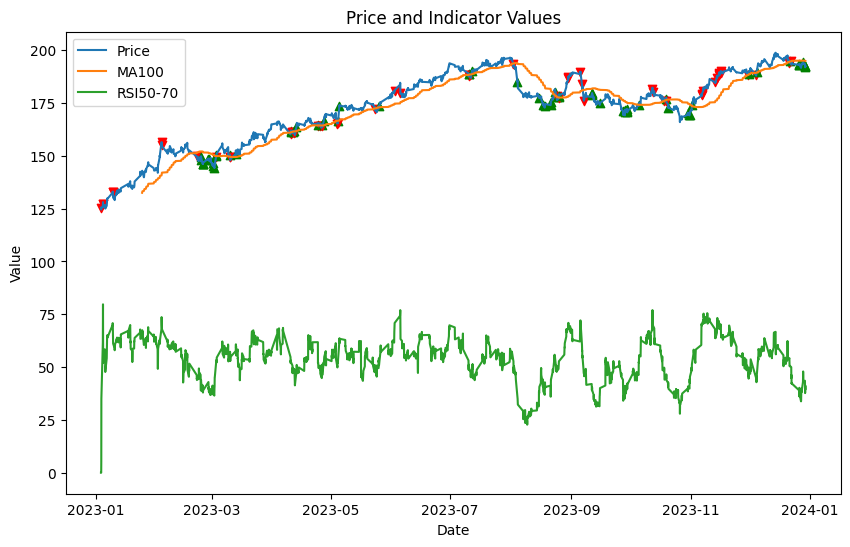

Profit: 7076.6760330200195	 Trade count: 121


In [62]:
# Example usage:
if __name__ == "__main__":

    # Create backtester object
    backtester = Backtester(data)


    MA_params = {
        'window': 100
    }
    RSI_params = {
        'window': 50,
        'upper_threshold': 70,
        'lower_threshold': 40
                  }

    MA_name = f'MA{MA_params["window"]}'
    RSI_name = f'RSI{RSI_params["window"]}-{RSI_params["upper_threshold"]}'

    # Define and add indicators
    backtester.add_indicator(MovingAverage(name=MA_name, parameters=MA_params), 1)
    backtester.add_indicator(RSI(name=RSI_name, parameters=RSI_params), 1)

    # Run strategy
    backtester.run_strategy()

    profit, trade_count = backtester.calculate_profit()

    # Plot results
    backtester.plot_results()



    print(f"Profit: {profit}\t Trade count: {trade_count}")